In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append("/workspaces/MambaLinearCode")
os.chdir("/workspaces/MambaLinearCode")


In [2]:
from configuration import Code, Config
from dataset import get_generator_and_parity
import torch
import os
import logging

def code_from_hint(hint,):
    code_files = os.listdir(CODES_PATH)
    code_files = [f for f in code_files if hint in f][0]
    print(code_files)
    code_n = int(code_files.split('_')[1][1:])
    code_k = int(code_files.split('_')[-1][1:].split('.')[0])
    code_type = code_files.split('_')[0]
    code = Code(code_n, code_k, code_type)
    return code

OUTPUT_PATH = ".output2/"
CODES_PATH = "codes/"
example_code = code_from_hint("LDPC_N49_K24")
G,H = get_generator_and_parity(example_code, standard_form=True)
example_code.generator_matrix = torch.from_numpy(G).transpose(0,1).long()
example_code.pc_matrix = torch.from_numpy(H).long()

os.makedirs(OUTPUT_PATH, exist_ok=True)
config = Config(
    code=example_code,
    d_model=32,
    d_state=64,
    path=OUTPUT_PATH,
    N_dec=1,
    warmup_lr=1.0e-4,
    lr=10e-4,
    batch_size=128,
    epochs=1000
)

handlers = [
        logging.FileHandler(os.path.join(OUTPUT_PATH, 'logging.txt')),
        logging.StreamHandler()
    ]
logging.basicConfig(level=logging.INFO, format='%(message)s',
                    handlers=handlers)

LDPC_N49_K24.alist


In [3]:
from mamba_ssm import Mamba
from dataset import EbN0_to_std, ECC_Dataset, train, test, sign_to_bin, bin_to_sign
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torch.nn import ModuleList, LayerNorm
import copy

device = "cuda"

def clones(module, N):
    return ModuleList([copy.deepcopy(module) for _ in range(N)])

def build_mask(code):
    mask_size = code.n + code.pc_matrix.size(0)
    mask = torch.eye(mask_size, mask_size)
    for ii in range(code.pc_matrix.size(0)):
        idx = torch.where(code.pc_matrix[ii] > 0)[0]
        for jj in idx:
            for kk in idx:
                if jj != kk:
                    mask[jj, kk] += 1
                    mask[kk, jj] += 1
                    mask[code.n + ii, jj] += 1
                    mask[jj, code.n + ii] += 1
    src_mask = ~(mask > 0).unsqueeze(0).unsqueeze(0)
    return src_mask

def get_syndrome(x, pc_matrix):
    return bin_to_sign(torch.matmul(
        (pc_matrix).unsqueeze(0).float(),
        sign_to_bin(torch.sign(x))
    ) % 2)

class EncoderLayer(torch.nn.Module):
    def __init__(self, config: Config) -> None:
        super().__init__()
        self.seq_len = config.code.n
        self.d_model = config.code.pc_matrix.shape[0]
        self.Sa = torch.nn.Linear(self.d_model, 1, bias=False)
        self.Sb = torch.nn.Linear(self.d_model, 1, bias=False)
        self.Sc = torch.nn.Linear(self.d_model, 1, bias=False)
        self.resize_output = torch.nn.Linear(self.d_model,1)
        self.norm_output = LayerNorm((self.seq_len,1))
        self.activation = F.softmax
        self.register_buffer("pc_matrix", config.code.pc_matrix.float())
        self.register_buffer("syndrome_connection", torch.eye(self.d_model))
        
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)
        
        # For tests:
        Azer = torch.zeros_like(self.Sa.weight)
        Bzer = torch.zeros_like(self.Sb.weight)
        Czer = torch.zeros_like(self.Sc.weight)
        with torch.no_grad():
            self.Sa.weight.copy_(Azer)
            self.Sb.weight.copy_(Bzer)
            self.Sc.weight.copy_(Czer)
        
        # Azer = torch.randn_like(self.Sa.weight)
        # Bzer = torch.randn_like(self.Sb.weight)
        # Czer = torch.randn_like(self.Sc.weight)
        # with torch.no_grad():
        #     self.Sa.weight.copy_(Azer)
        #     self.Sb.weight.copy_(Bzer)
        #     self.Sc.weight.copy_(Czer)

        

    def _retrieve(self, y, states):
        out = torch.zeros_like(y)
        out[...,0,:] = y[...,0,:]
        for i in range(1,self.seq_len):
            out[...,i,:] = y[...,i,:] * states[...,i-1,:]
        out = out.sum(-1,keepdim=True)
        return -out
    
    def _ssm_iteration(self, X,A,B,C,h,y,states, pc_matrix):
        pi = B * pc_matrix
        A_ij = - A * pc_matrix * h
        h = h + A_ij + pi # The default assumption is no error therefore we should stay at the same state.
        y = C * (h @ pc_matrix).unsqueeze(-1)
        return h,h,y
    
    def _ssm_calc(self, X, pc_matrix, h):
        """
        X: (B,L,p)
        pc_matrix: (p,L)
        h: (B,p)

        where:
        B - batch
        L - Length
        p - PC check count
        """
        y = torch.zeros_like(X)[...,:1] # TODO: fix this
        states = torch.zeros_like(X)
        has_errors = torch.any(h != 1,dim=-1,keepdim=True).unsqueeze(-1) # (B,1,1)
        # Taking a viterbi-like approach
        # A: Transition matrix proportional to <s_i, h>, if h and s_i don't belong to the same lane this would be negative.
        # B: Initial probabilty matrix, p(e_i = true) = f(|x|,syn@pc[:,i])
        # C: Emmision matrix, p(e_i=true| s_i).
        A = 1.0 # self.Sa(X)
        B = (h @ pc_matrix).unsqueeze(-1) + \
            self.Sb(torch.abs(X))
            # h0 = syndrome
        C = 0.5 + self.Sc(torch.abs(X))
        
        for i in range(self.seq_len):
            h, states[..., i, :], y[..., i, :] = self._ssm_iteration(
                X[..., i, :],
                A,
                B[...,i,:],
                C[...,i,:],
                h,
                y[..., i, :],
                states[..., i, :],
                self.pc_matrix[:,i]
            )
        
        return y* has_errors, B, C , states

    def _forward_pass(self, X, h=None):
        return self._ssm_calc(X,self.pc_matrix, h)
    
    def _reverse_pass(self,X,h=None):# -> tuple[Tensor, Any, Any, float | Any]:
        r = self._ssm_calc(torch.flip(X,[1]),torch.flip(self.pc_matrix,[1]), h)
        return tuple(torch.flip(M,[1]) for M in r)
    
    def _bider_pass(self, X, h=None):
        y1,B1,C1,h1 = self._forward_pass(X,h)
        y2,B2,C2,h2 = self._reverse_pass(X,h)
        return y1, y2, B1, C1, h1
    
    def embed(self, X):
        X = X * self.pc_matrix.T
        return X
        
    def forward(self, X, h=None):
        if h is None:
            h = get_syndrome(X, self.pc_matrix).squeeze(-1)
        X = self.embed(X)
        y1,y2,*rest = self._bider_pass(X,h)
        out = y1+y2
        return self.activation(out, dim=-2)

class ErrToNoise(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.a = torch.nn.Linear(2, 2)
        self.b = torch.nn.Linear(2, 1)
    
    def forward(self, x, out):
        y = torch.concatenate([x, out], -1)
        y = F.relu(self.a(y))
        return F.tanh(self.b(y))
    
class ECCM(torch.nn.Module):
    def __init__(self, config: Config) -> None:
        super().__init__()
        self.n = config.code.n
        self.seq_len = self.n
        self.d_model = config.code.pc_matrix.size(0)
        # self.src_embed = torch.nn.Parameter(torch.ones(
        #     (self.seq_len, self.d_model)))
        self.register_buffer("pc_matrix", config.code.pc_matrix)
        self.err_to_noise = ErrToNoise()
        self.resize_output_dim = torch.nn.Linear(self.d_model, 1)
        
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

        self.mamba: ModuleList = ModuleList([EncoderLayer(config,) for _ in range(config.N_dec)])
        self.activation = F.softmax
        
    
    def forward(self, x, syndrome):
        x = x.unsqueeze(-1)
        out = torch.zeros_like(x)
        z = torch.zeros_like(x)
        for sublayer in self.mamba:
            diff = sublayer.forward(x-z)
            out = diff + out
            z = self.err_to_noise(x,out)
        return F.tanh(out)

    def loss(self, z_pred, z2, y):
        loss = F.binary_cross_entropy(z_pred, z2)
        x_pred = sign_to_bin(torch.sign(bin_to_sign(z_pred)) * torch.sign(y))
        return loss, x_pred
model = ECCM(config=config).to("cuda")

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([49, 49, 28])


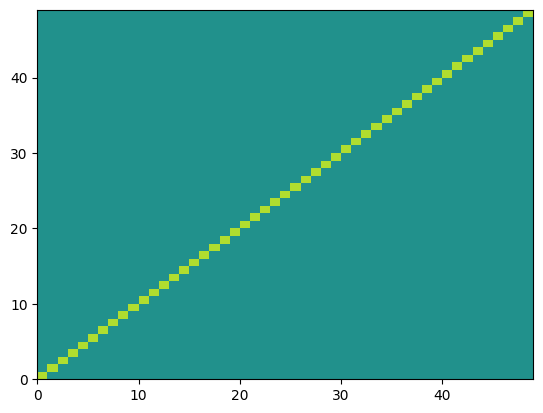

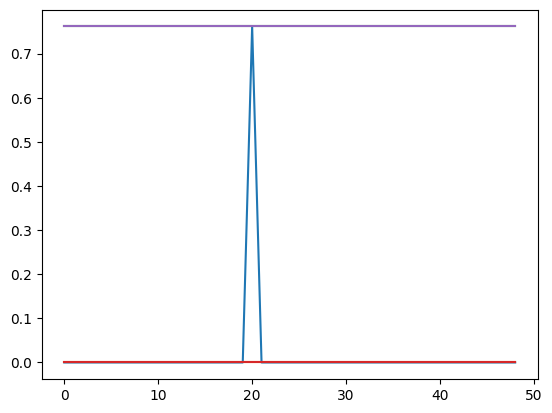

In [4]:
from matplotlib import pyplot as plt
from dataset import bin_to_sign
code = config.code 
EbNo_range_train = [10]
std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
m,x,z,y,mag,syn = ECC_Dataset(code, std_train, len=config.batch_size * 1000, zero_cw=False)[0]

x = (torch.eye(len(x))-0.5)*2
y = x

x = torch.zeros((config.code.n,config.code.n))
y = -bin_to_sign(x + torch.eye(config.code.n))
print(model.mamba[0].embed(y.unsqueeze(-1).to('cuda')).shape)
out = model(y.to('cuda'),syn.to('cuda'))
# print(out)
# loss, x_pred = model.loss(out[...,0], sign_to_bin(y).to('cuda'), y.to('cuda'))
# plt.figure()
# plt.pcolormesh(x_pred.detach().cpu().numpy())
model.zero_grad()
plt.figure()
plt.pcolormesh(out.squeeze(-1).detach().cpu().numpy(),vmin=-1,vmax=1)
# loss
plt.figure()
plt.plot(out[20].detach().cpu().numpy().min(1))
plt.plot(out.detach().cpu().numpy().min(1))
plt.plot(out.detach().cpu().numpy().max(1))
plt.plot(out.detach().cpu().numpy().min(0))
plt.plot(out.detach().cpu().numpy().max(0))

In [5]:
model.mamba[0].Sc.weight

Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], device='cuda:0', requires_grad=True)

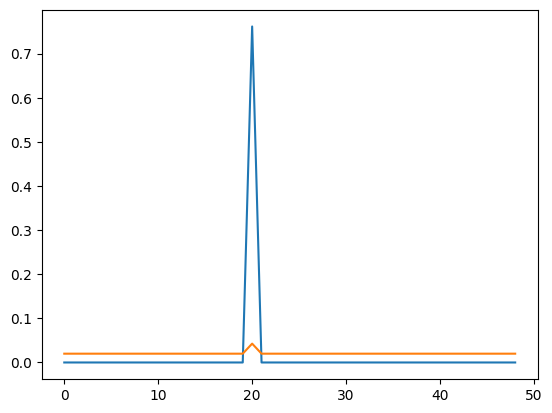

In [6]:
plt.figure()
plt.plot(out[20].detach().cpu().numpy())
plt.plot(F.softmax(out[20],0).detach().cpu().numpy())


In [7]:
torch.sign(bin_to_sign(out[0].T))

tensor([[-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.]], device='cuda:0',
       grad_fn=<SignBackward0>)

In [8]:
syn

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

torch.Size([49, 1])


Text(0.5, 1.0, 'errors')

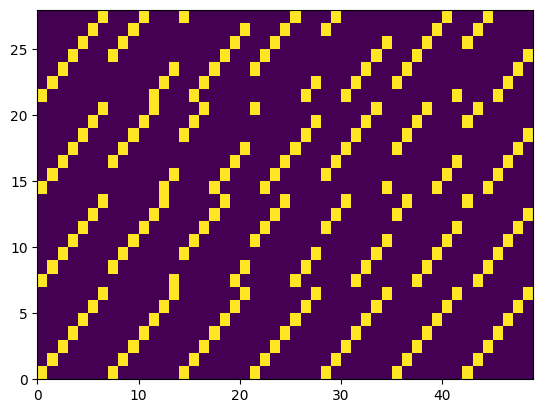

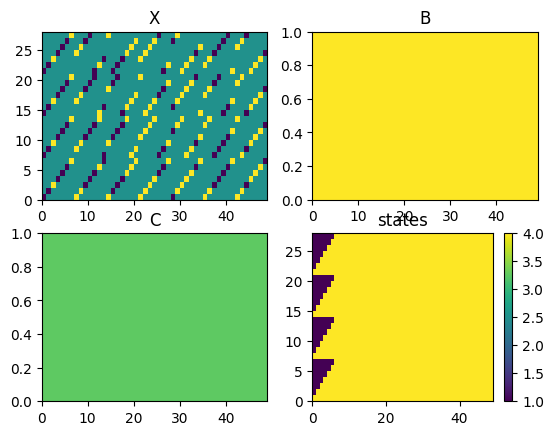

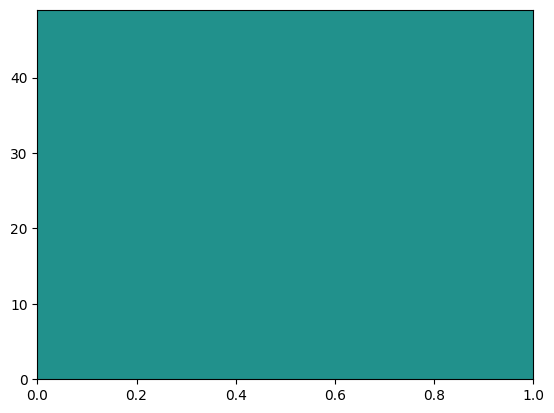

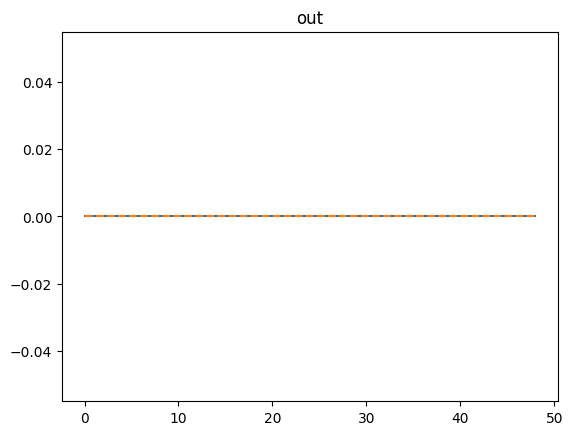

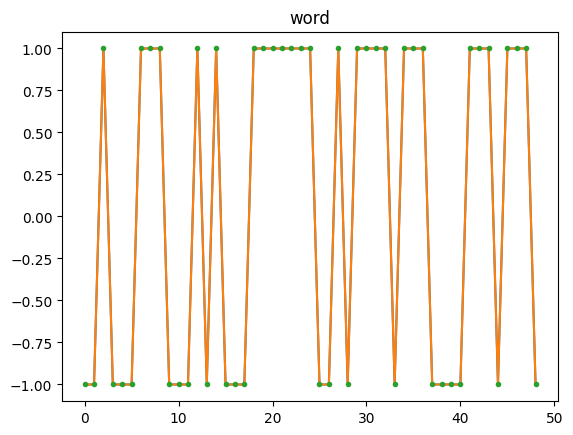

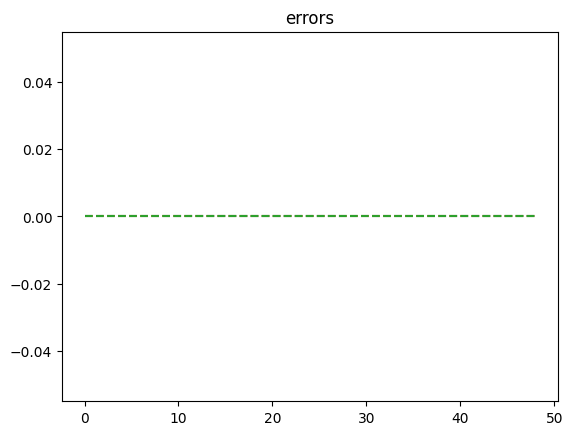

In [9]:
self = model.mamba[0]
code = config.code 
EbNo_range_train = [2]
std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
m,x,z,y,mag,syn = ECC_Dataset(code, std_train, len=config.batch_size * 1000, zero_cw=False)[0]

random_indices = torch.randint(0, x.shape[0], (1,))
y = bin_to_sign(x)
# y[random_indices] *= -1

X = y.unsqueeze(0).unsqueeze(-1).to('cuda')
syn = get_syndrome(X, self.pc_matrix).squeeze(-1)
X = self.embed(X)

out, out2, B, C, states = self._bider_pass(X, syn)
out += out2
# out, B, C, states = self._forward_pass(X, syn)
# out = self.resize_output(out)
# out = self.activation(out, dim=-2)
out = out[0]
print(out.shape)

plt.figure()
plt.pcolormesh(code.pc_matrix)
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2)
ax1.pcolormesh((X)[0].detach().cpu().numpy().T,vmin=-1,vmax=1)
ax1.set_title('X')
ax2.pcolormesh((B[0]).detach().cpu().numpy().T,vmin=-1,vmax=1)
ax2.set_title('B')
ax3.pcolormesh(C[0].detach().cpu().numpy().T,vmin=-1,vmax=1)
ax3.set_title('C')
pc = ax4.pcolormesh((states[0]).detach().cpu().numpy().T,)
ax4.figure.colorbar(pc)
ax4.set_title('states')

plt.figure()
plt.pcolormesh(out.detach().cpu().numpy(), vmin=-1,vmax=1)

out = out[...,0].detach().cpu()/(out.detach().cpu().numpy().max()+1e-10)
out2 = out2[0,...,0].detach().cpu()/(out2.detach().cpu().numpy().max()+1e-10)
plt.figure()
plt.plot(out)
plt.plot(out2, ls="--")
plt.title("out")
plt.figure()
line_x, = plt.plot(bin_to_sign(x))
line_y, = plt.plot(y)
line_out, = plt.plot(torch.sign(bin_to_sign(out))*y, '. ')
plt.title("word")

plt.figure()
plt.plot((x!=0) ^ (y<0), c=line_x.get_color(), ls="--")
plt.plot((y * bin_to_sign(x)) < 0, c=line_y.get_color(), ls="--")
line_out, = plt.plot(out, c=line_out.get_color(), ls="--")
plt.title("errors")


In [10]:
states[0,0],syn

(tensor([4., 1., 1., 1., 1., 1., 1., 4., 1., 1., 1., 1., 1., 1., 4., 1., 1., 1.,
         1., 1., 1., 4., 1., 1., 1., 1., 1., 1.], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0'))

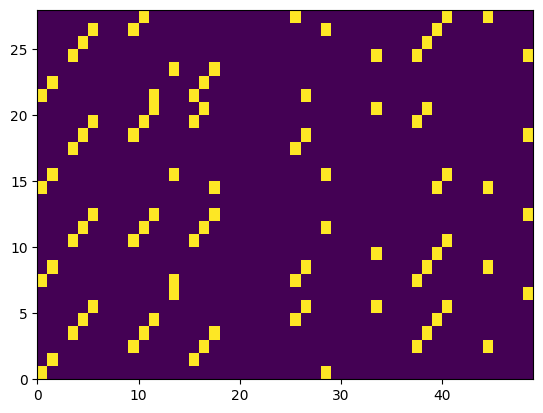

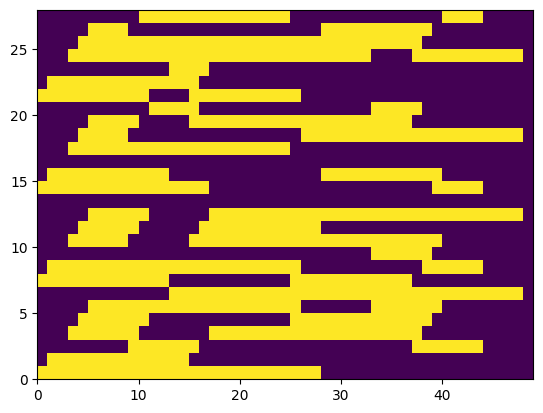

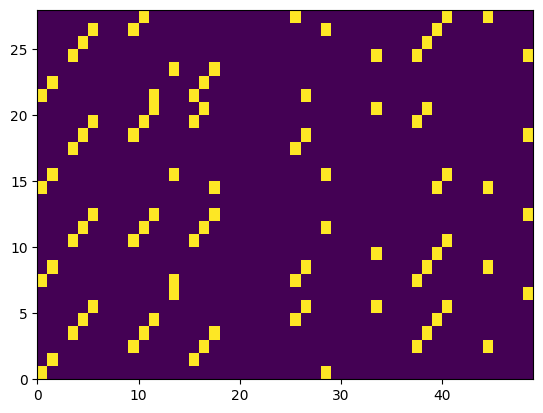

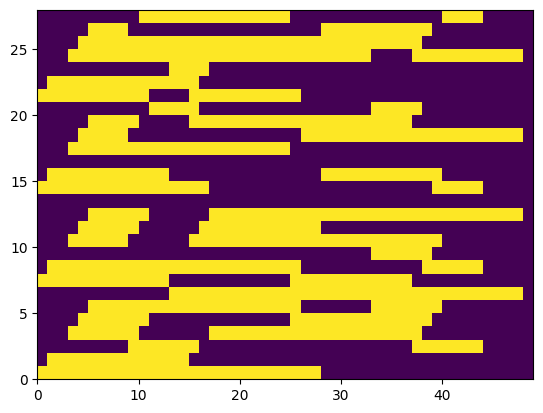

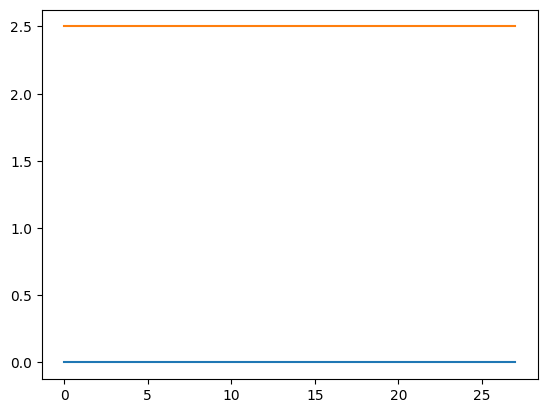

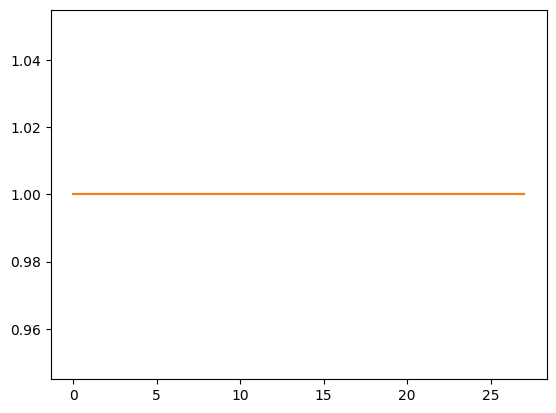

In [11]:
plt.figure()
plt.pcolormesh((x) * code.pc_matrix)
plt.figure()
plt.pcolormesh(((x) * code.pc_matrix).cumsum(-1)%2)
plt.figure()
plt.pcolormesh(sign_to_bin(torch.sign(y)) * code.pc_matrix)
plt.figure()
plt.pcolormesh((sign_to_bin(torch.sign(y)) * code.pc_matrix).cumsum(-1)%2)
plt.figure()
plt.plot((sign_to_bin(torch.sign(y)) * code.pc_matrix).sum(-1)%2)
plt.plot(sign_to_bin(-states[0].detach().cpu().numpy()[-1]))

plt.figure()
plt.plot(code.pc_matrix.float() @ bin_to_sign(x) % 2)
plt.plot(code.pc_matrix.float() @ torch.sign(y) % 2)

In [12]:
model

ECCM(
  (err_to_noise): ErrToNoise(
    (a): Linear(in_features=2, out_features=2, bias=True)
    (b): Linear(in_features=2, out_features=1, bias=True)
  )
  (resize_output_dim): Linear(in_features=28, out_features=1, bias=True)
  (mamba): ModuleList(
    (0): EncoderLayer(
      (Sa): Linear(in_features=28, out_features=1, bias=False)
      (Sb): Linear(in_features=28, out_features=1, bias=False)
      (Sc): Linear(in_features=28, out_features=1, bias=False)
      (resize_output): Linear(in_features=28, out_features=1, bias=True)
      (norm_output): LayerNorm((49, 1), eps=1e-05, elementwise_affine=True)
    )
  )
)

tensor(0.0695, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


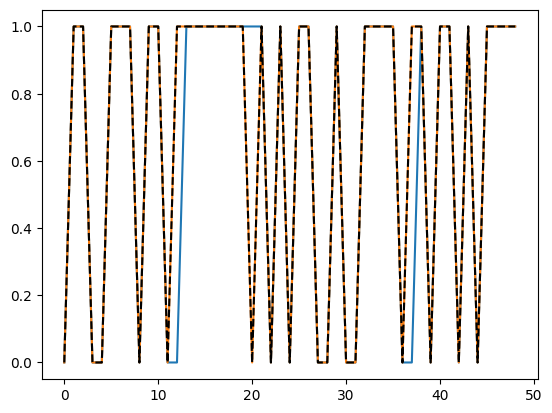

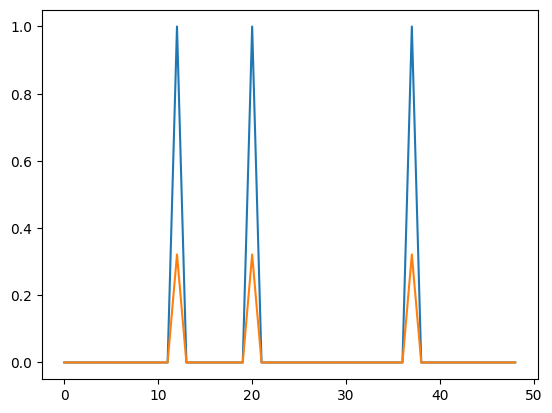

In [13]:
model = ECCM(config=config).to("cuda")
EbNo_range_train = [5]
std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
m,x,z,y,mag,syn = ECC_Dataset(code, std_train, len=config.batch_size * 1000, zero_cw=False)[0]
x = x.unsqueeze(0)
y = y.unsqueeze(0)

# x = torch.zeros((config.code.n,config.code.n))
# y = bin_to_sign(x)
# random_indices = torch.randint(0, x.shape[1], (x.shape[0],))
# y[torch.arange(x.shape[0]), random_indices] *= -1

z_mul = sign_to_bin(torch.sign(torch.sign(y) * bin_to_sign(x)))
z_pred = model(-torch.sign(y).to(device), syn.to(device)).squeeze(-1)
loss, x_pred = model.loss(z_pred, z_mul.to(device), y.to(device))

plt.figure()
plt.plot(x[0])
plt.plot(sign_to_bin(torch.sign(y[0])))
plt.plot(x_pred.detach().cpu().numpy()[0],'k--')

plt.figure()
plt.plot(z_mul.detach().cpu().numpy()[0])
plt.plot(z_pred.detach().cpu().numpy()[0])
print(loss)

In [14]:
import time
from dataset import bin_to_sign, BER, FER
from tqdm import tqdm
import numpy as np

def apply_model(model, x,y,syndrome,device):
    z_mul = sign_to_bin(torch.sign(torch.sign(y) * bin_to_sign(x)))
    z_pred = model(-y.to(device), syndrome.to(device)).squeeze(-1)
    loss, x_pred = model.loss(z_pred, z_mul.to(device), y.to(device))
    return loss, x_pred

def train(model, device, train_loader, optimizer, epoch, LR, config: Config):
    model.train()
    cum_loss = cum_ber = cum_fer = cum_samples = cum_loss = 0.
    t = time.time()
    batch_idx = 0
    for m, x, z, y, magnitude, syndrome in tqdm(train_loader, position=0, leave=True, desc="Training"):
        # TODO: Organize this!
        # random_indices = torch.randint(0, x.shape[1], (x.shape[0],))
        # y = bin_to_sign(x)
        # y[torch.arange(x.shape[0]), random_indices] *= -1
        loss, x_pred = apply_model(model, x,y,syndrome,device)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        ###
        ber = BER(x_pred, x.to(device))
        fer = FER(x_pred, x.to(device))

        cum_loss += loss.item() * x.shape[0]
        cum_ber += ber * x.shape[0]
        cum_fer += fer * x.shape[0]
        cum_samples += x.shape[0]
        if batch_idx == len(train_loader) - 1:
            logging.info(
                f'Training epoch {epoch}, Batch {batch_idx + 1}/{len(train_loader)}: LR={LR:.2e}, Loss={cum_loss / cum_samples:.2e} BER={cum_ber / cum_samples:.2e} FER={cum_fer / cum_samples:.2e}')
        batch_idx += 1
    logging.info(f'Epoch {epoch} Train Time {time.time() - t}s\n')
    return cum_loss / cum_samples, cum_ber / cum_samples, cum_fer / cum_samples

def test(model, device, test_loader_list, EbNo_range_test, min_FER=100):
    model.eval()
    t = time.time()
    with torch.no_grad():
        for ii, test_loader in enumerate(test_loader_list):
            test_loss = test_ber = test_fer = cum_count = test_in_err = 0.
            for m, x, z, y, magnitude, syndrome in tqdm(test_loader, position=0, leave=True, desc="Testing"):
                loss, x_pred = apply_model(model, x,y,syndrome,device)
                
                test_loss += loss.item() * x.shape[0]
                test_in_err += BER(sign_to_bin(torch.sign(y)),x) * x.shape[0]
                test_ber += BER(x_pred, x.to(device)) * x.shape[0]
                test_fer += FER(x_pred, x.to(device)) * x.shape[0]
                cum_count += x.shape[0]
            test_loss /= cum_count
            test_ber /= cum_count
            test_fer /= cum_count
            test_in_err /= cum_count
            ln_ber = -np.log(test_ber)
            logging.info(f'Test EbN0={EbNo_range_test[ii]}, BER={test_ber:.2e} in_err={test_in_err:.2e}, -ln(BER)={ln_ber:.2e} loss={test_loss:.2e}' )

def train_model(args: Config, model: torch.nn.Module):
    code = args.code
    initial_lr = args.warmup_lr
    device = "cuda" if torch.cuda.is_available() else "cpu"
    optimizer = Adam(model.parameters(), lr=args.warmup_lr)

    # model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
    # optimizer.load_state_dict(torch.load(os.path.join(config.path, 'optimizer_checkpoint')))
    

    #################################
    EbNo_range_test = range(0, 11)
    EbNo_range_train = range(2,8)
    std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
    train_dataloader = DataLoader(ECC_Dataset(code, std_train, len=args.batch_size * 50, zero_cw=False), batch_size=int(args.batch_size),
                                  shuffle=True, num_workers=args.workers)
    
    std_test = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_test]
    test_dataloader_list = [DataLoader(ECC_Dataset(code, [std_test[ii]], len=int(args.test_batch_size), zero_cw=False),
                                       batch_size=int(args.test_batch_size), shuffle=False, num_workers=args.workers) for ii in range(len(std_test))]
    #################################

    best_loss = float('inf')
    # for epoch in range(1,3):
    #     loss, ber, fer = train(model, device, train_dataloader, optimizer,
    #                            epoch, LR=initial_lr, config=args)
    #     if loss < best_loss:
    #         best_loss = loss
    #         torch.save(model.state_dict(), os.path.join(args.path, 'best_model'))
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = args.lr
    
    scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=args.eta_min)
    # scheduler.load_state_dict(torch.load(os.path.join(config.path, 'scheduler_checkpoint')))
    test(model, device, test_dataloader_list, EbNo_range_test)
    for epoch in range(1, args.epochs + 1):
        loss, ber, fer = train(model, device, train_dataloader, optimizer,
                               epoch, LR=scheduler.get_last_lr()[0], config=args)
        scheduler.step()
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), os.path.join(args.path, 'best_model'))
            torch.save(optimizer.state_dict(), os.path.join(args.path, 'optimizer_checkpoint'))
            torch.save(scheduler.state_dict(), os.path.join(args.path, 'scheduler_checkpoint'))

        if epoch % 10 == 0:
            test(model, device, test_dataloader_list, EbNo_range_test)
    return model

train_model(config, model)

Testing: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
Test EbN0=0, BER=1.63e-01 in_err=1.62e-01, -ln(BER)=1.81e+00 loss=2.30e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
Test EbN0=1, BER=1.34e-01 in_err=1.33e-01, -ln(BER)=2.01e+00 loss=1.71e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
Test EbN0=2, BER=1.04e-01 in_err=1.05e-01, -ln(BER)=2.26e+00 loss=1.16e+00
Testing: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
Test EbN0=3, BER=7.86e-02 in_err=8.14e-02, -ln(BER)=2.54e+00 loss=7.19e-01
Testing: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
Test EbN0=4, BER=5.17e-02 in_err=5.73e-02, -ln(BER)=2.96e+00 loss=3.42e-01
Testing: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
Test EbN0=5, BER=3.05e-02 in_err=3.77e-02, -ln(BER)=3.49e+00 loss=1.48e-01
Testing: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
Test EbN0=6, BER=1.39e-02 in_err=2.19e-02, -ln(BER)=4.28e+00 loss=4.98e-02
Testing: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]
Test EbN0=7, BER=6.02e-03 in_err=1.

In [13]:
model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
def test(model, device, test_loader_list, EbNo_range_test, min_FER=100):
    model.eval()
    t = time.time()
    with torch.no_grad():
        for ii, test_loader in enumerate(test_loader_list):
            test_loss = test_ber = test_fer = cum_count = test_in_err = 0.
            for m, x, z, y, magnitude, syndrome in tqdm(test_loader, position=0, leave=True, desc="Testing"):
                loss, x_pred = apply_model(model, x,y,syndrome,device)
                
                test_loss += loss.item() * x.shape[0]
                test_in_err += BER(sign_to_bin(torch.sign(y)),x) * x.shape[0]
                test_ber += BER(x_pred, x.to(device)) * x.shape[0]
                test_fer += FER(x_pred, x.to(device)) * x.shape[0]
                cum_count += x.shape[0]
            test_loss /= cum_count
            test_ber /= cum_count
            test_fer /= cum_count
            test_in_err /= cum_count
            ln_ber = -np.log(test_ber)
            logging.info(f'Test EbN0={EbNo_range_test[ii]}, BER={test_ber:.2e} in_err={test_in_err:.2e}, -ln(BER)={ln_ber:.2e} loss={test_loss:.2e}' )

def _test(config, model):
    EbNo_range_test = range(0,11)
    code = config.code
    std_test = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_test]
    test_dataloader_list = [DataLoader(ECC_Dataset(code, [std_test[ii]], len=int(config.test_batch_size), zero_cw=False),
                                        batch_size=config.test_batch_size, shuffle=False, num_workers=1) for ii in range(len(std_test))]
    test(model, 'cuda', test_dataloader_list, EbNo_range_test)
_test(config, model)

/tmp/ipykernel_1537/396503996.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
Testing: 100%|██

In [14]:

# model = ECCM(config=config)
# model.load_state_dict(torch.load(os.path.join(config.path, 'best_model')))
# model = model.to("cuda")

ValueError: Using a target size (torch.Size([1, 49])) that is different to the input size (torch.Size([49, 1])) is deprecated. Please ensure they have the same size.

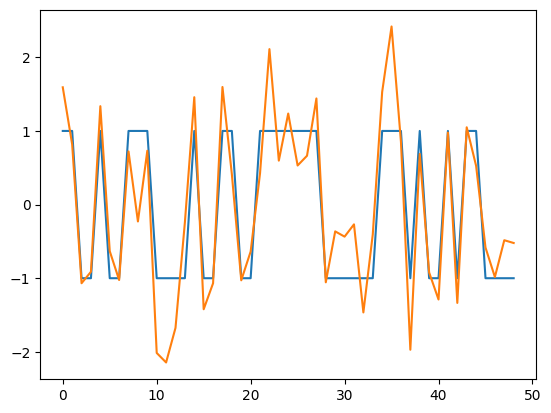

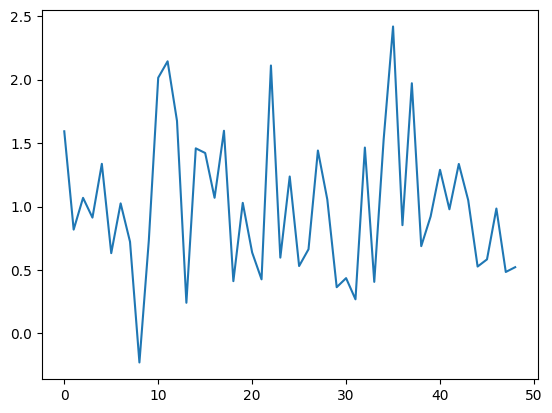

In [15]:
from dataset import bin_to_sign

code = config.code
EbNo_range_train = [5]
std_train = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_train]
m,x,z,y,mag,syn = ECC_Dataset(code, std_train, len=config.batch_size * 1000, zero_cw=False)[0]
z_mul = (y * bin_to_sign(x))
if len(z_mul.shape) < 2:
    z_mul = z_mul.unsqueeze(0)
z_pred = model(y.to('cuda'), syn.to('cuda'))

from matplotlib import pyplot as plt
plt.figure()
plt.plot(bin_to_sign(x))
plt.plot(y)
plt.figure()
plt.plot(z_mul.detach().cpu().numpy()[0])
plt.plot(-z_pred.detach().cpu().numpy()[0])
loss, xpred = model.loss(z_pred, z_mul.to('cuda'), y.to('cuda'))
plt.figure()
plt.plot(x)
plt.plot(xpred[0].detach().cpu().numpy(), ls="--")
loss

In [ ]:
# Ideas:
# Bi-directional
# Load and output

tensor(42)

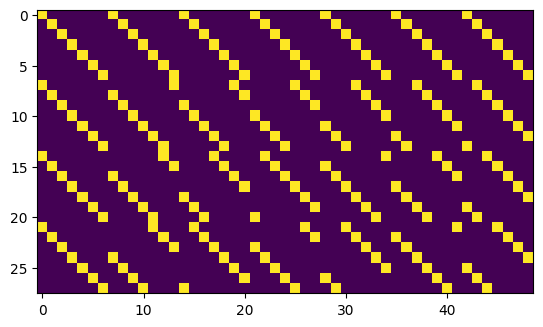

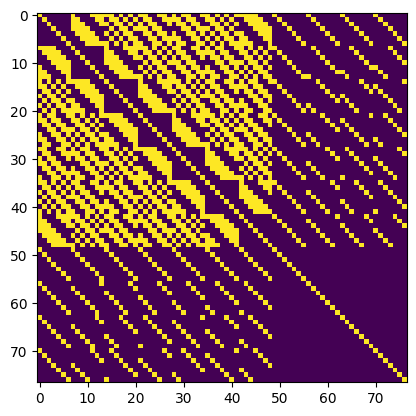

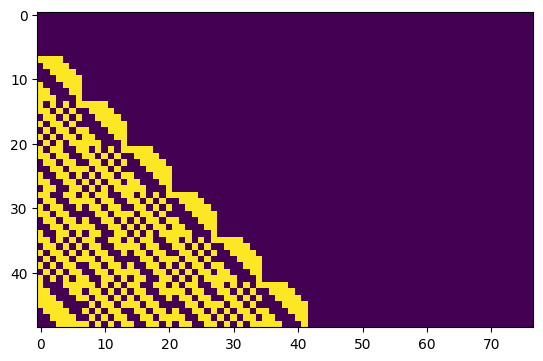

In [66]:
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(config.code.pc_matrix)


a = (~build_mask(config.code))[0,0].float()
b = torch.tril(a, diagonal=-1)


plt.figure()
plt.imshow(a)
plt.figure()
plt.imshow(b[:49])
torch.linalg.matrix_rank(b[:49])